In this file I am using TEXT (combination of Title, Tagline and Overview) vectorized using TF-IDF and REVENUE for the main features to predict Movie Genres. Following the steps I performed:
1. Preprocess the dataset deeply, since TF-IDF needs clean data to be vectorized. I diD preprocessing for both Train Dataset and Test Dataset.
2. Split the Train Dataset to be used in Modelling. It would be split into X_train, y_train, X_test, y_test.
3. Vectorize the X_train, X_test using TF-IDF. Apply scaler for Revenue.
4. Perform modelling using Random Forest, Log Regression, SVC, and MLP Method.
5. So far, Log Regression give the best result either by F1 metrics or coverage-length metrics.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report



In [3]:
from google.colab import files
uploaded = files.upload()


Saving cleaned_test.csv to cleaned_test.csv
Saving cleaned_train.csv to cleaned_train.csv


In [4]:
df_train = pd.read_csv('cleaned_train.csv')
df_test = pd.read_csv('cleaned_test.csv')

In [ ]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           857 non-null    object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            1965 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

In [5]:
# Dealing with null values
df_train['tagline'].fillna('-', inplace=True)

df_train['homepage'].fillna('-', inplace=True)


<ipython-input-5-05107497b945>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['tagline'].fillna('-', inplace=True)
<ipython-input-5-05107497b945>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2386 non-null   int64  
 1   budget             2386 non-null   float64
 2   homepage           2386 non-null   object 
 3   original_language  2386 non-null   object 
 4   original_title     2386 non-null   object 
 5   overview           2386 non-null   object 
 6   release_date       2386 non-null   object 
 7   revenue            2386 non-null   float64
 8   runtime            2386 non-null   float64
 9   status             2386 non-null   object 
 10  tagline            2386 non-null   object 
 11  title              2386 non-null   object 
 12  vote_average       2386 non-null   float64
 13  vote_count         2386 non-null   float64
 14  Action             2386 non-null   int64  
 15  Adventure          2386 non-null   int64  
 16  Animation          2386 

### 1. PREPROCESS THE TEXT COLUMNS

In [6]:
!pip install unidecode


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.1 MB/s eta 0:00:00


In [7]:
import html
import string
import unidecode
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download semua resource yang dibutuhkan
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Initialize objects
lemmatizer = WordNetLemmatizer()
default_stopwords = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {
    'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x', 'i',
    'movie', 'film', 'new', 'story', 'th', 'man', 'men', 'woman', 'women',
    'boy', 'girl', 'world', 'life'
}
all_stopwords = default_stopwords.union(custom_stopwords)

# Remove punctuation
punctuation_table = str.maketrans('', '', string.punctuation)

# POS tag mapper
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Main preprocessing function
def text_preprocess(sentence):
    """
    Preprocesses a single text string:
    - Removes HTML tags/entities, URLs, emails
    - Normalizes to lowercase and ASCII
    - Removes punctuation and numbers
    - Tokenizes and lemmatizes with POS tags
    - Removes stopwords and short words
    """
    if not isinstance(sentence, str) or not sentence.strip():
        return ""

    # Lowercase
    sentence = sentence.lower()

    # Remove HTML tags and entities
    sentence = html.unescape(re.sub(r'<[^>]+>', '', sentence))

    # Remove URLs and emails
    sentence = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', sentence, flags=re.MULTILINE)

    # Remove punctuation and numbers
    sentence = sentence.translate(punctuation_table)
    sentence = re.sub(r'\d+', '', sentence)

    # Normalize accents
    sentence = unidecode.unidecode(sentence)

    # Tokenize
    words = word_tokenize(sentence)

    # POS tagging
    tagged_words = pos_tag(words)

    # Lemmatization with filtering
    processed_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in tagged_words
        if word.isalpha() and word not in all_stopwords and len(word) > 2
    ]

    return ' '.join(processed_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [8]:
import pandas as pd

# COMBINE
    return df['processed_title'] + ' ' + df['processed_tagline'] + ' ' + df['processed_overview']

preprocessed_data = False

if not preprocessed_data:
    for df in [df_train, df_test]:
        df['processed_title'] = df['title'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')
        df['processed_tagline'] = df['tagline'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')
        df['processed_overview'] = df['overview'].apply(lambda x: text_preprocess(str(x)) if pd.notnull(x) else '')

    # Gabungkan semua teks yang sudah dibersihkan
    df_train['text'] = combine_processed_text(df_train)
    df_test['text'] = combine_processed_text(df_test)

    # Simpan hasil
    df_train.to_csv('movies_genres_train_preprocessed.csv', index=False)
    df_test.to_csv('movies_genres_test_preprocessed.csv', index=False)

    preprocessed_data = True


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train['revenue_scaled'] = scaler.fit_transform(df_train[['revenue']])
df_test['revenue_scaled'] = scaler.transform(df_test[['revenue']])


In [10]:
##Checkpoint: The preprocessed columns
genre_columns = df_train.columns[14:34]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2386 entries, 0 to 2385
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2386 non-null   int64  
 1   budget              2386 non-null   float64
 2   homepage            2386 non-null   object 
 3   original_language   2386 non-null   object 
 4   original_title      2386 non-null   object 
 5   overview            2386 non-null   object 
 6   release_date        2386 non-null   object 
 7   revenue             2386 non-null   float64
 8   runtime             2386 non-null   float64
 9   status              2386 non-null   object 
 10  tagline             2386 non-null   object 
 11  title               2386 non-null   object 
 12  vote_average        2386 non-null   float64
 13  vote_count          2386 non-null   float64
 14  Action              2386 non-null   int64  
 15  Adventure           2386 non-null   int64  
 16  Animat

### 2. SPLITTING THE TRAIN DATASET (with Text and Revenue as features)

In [11]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.2 MB/s eta 0:00:00


In [12]:
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

# Feature
X_text = df_train['text'].values.reshape(-1, 1)  # tetap 2D untuk split
X_revenue = df_train['revenue_scaled'].values.reshape(-1, 1)  # fitur tambahan

# Combine features
X_combined = np.hstack([X_text, X_revenue])

# Target (multi-label genre)
genre_columns = df_train.columns[14:34]
y = df_train[genre_columns].values

# Split
X_train_combined, y_train, X_test_combined, y_test = iterative_train_test_split(
    X_combined, y, test_size=0.2
)

X_train_text = X_train_combined[:, 0]
X_test_text = X_test_combined[:, 0]

X_train_revenue = X_train_combined[:, 1].astype(float)  # pastikan float
X_test_revenue = X_test_combined[:, 1].astype(float)


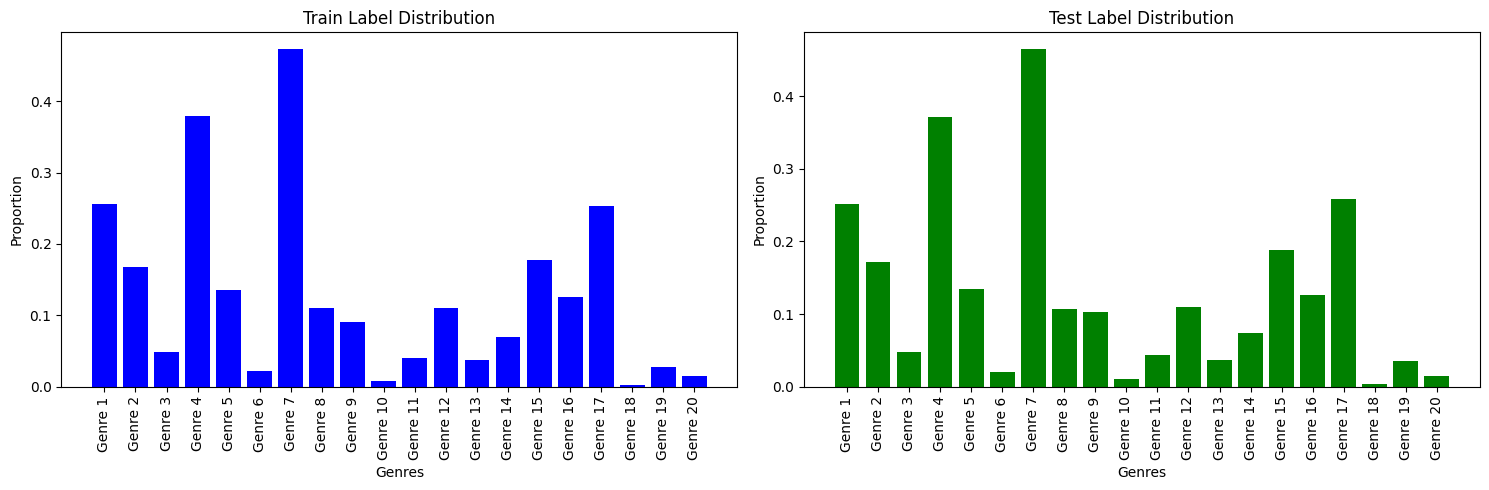

In [ ]:
# Checkpoint
import numpy as np
import matplotlib.pyplot as plt

def label_distribution(y):
    return np.sum(y, axis=0) / y.shape[0]

train_distribution = label_distribution(y_train)
test_distribution = label_distribution(y_test)

# Plotting the bar chart
labels = [f"Genre {i+1}" for i in range(len(train_distribution))]  # Replace with actual genre names if available

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Train label distribution bar chart
ax[0].bar(labels, train_distribution, color='blue')
ax[0].set_title("Train Label Distribution")
ax[0].set_xlabel("Genres")
ax[0].set_ylabel("Proportion")
ax[0].tick_params(axis='x', rotation=90)

# Test label distribution bar chart
ax[1].bar(labels, test_distribution, color='green')
ax[1].set_title("Test Label Distribution")
ax[1].set_xlabel("Genres")
ax[1].set_ylabel("Proportion")
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



### 3. VECTORIZE THE TEXT USING TF-IDF AND SCALE REVENUE

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack  # karena TF-IDF hasilnya sparse matrix
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Combine TF-IDF + revenue
X_train_final = hstack([X_train_tfidf, X_train_revenue.reshape(-1, 1)])
X_test_final = hstack([X_test_tfidf, X_test_revenue.reshape(-1, 1)])



### 4. MODELLING

### 4.1. LOG REGRESSION

In [15]:
# Model
lr = OneVsRestClassifier(
    LogisticRegression(max_iter=3000, class_weight='balanced')
)
lr.fit(X_train_final, y_train)


OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=3000))

In [17]:
import numpy as np

# Probabilitas prediksi (n_samples, n_labels)
y_test_probs_lr = np.array([
    estimator.predict_proba(X_test_final)[:, 1]
    for estimator in lr.estimators_
]).T

def build_conformal_sets(y_prob, threshold):
    return (y_prob >= threshold).astype(int)

def evaluate_conformal_sets(y_true, y_pred_sets):
    n = y_true.shape[0]

    is_covered = [
        set(np.where(y_true[i] == 1)[0]).issubset(set(np.where(y_pred_sets[i] == 1)[0]))
        for i in range(n)
    ]
    coverage = 1 if np.mean(is_covered) >= 0.9 else 0

    avg_len = np.mean(np.sum(y_pred_sets, axis=1))
    length = 1 - (avg_len / y_true.shape[1])

    metric = 0.5 * (coverage + length)

    return coverage, length, metric



In [18]:
thresholds = np.linspace(0.1, 0.9, 17)
best_metric = -1
best_threshold = None

for t in thresholds:
    y_pred_lr_val = build_conformal_sets(y_test_probs_lr, t)
    coverage, length, metric = evaluate_conformal_sets(y_test, y_pred_lr_val)
    print(f"Threshold={t:.2f} | Coverage={coverage} | Length={length:.4f} | Metric={metric:.4f}")

    if metric > best_metric:
        best_metric = metric
        best_threshold = t

print(f"\n✅ Best Threshold (Validation): {best_threshold:.2f}")
print(f"📊 Best Simulated Metric (Kaggle-style): {best_metric:.4f}")


Threshold=0.10 | Coverage=1 | Length=0.1641 | Metric=0.5820
Threshold=0.15 | Coverage=1 | Length=0.2908 | Metric=0.6454
Threshold=0.20 | Coverage=1 | Length=0.4202 | Metric=0.7101
Threshold=0.25 | Coverage=0 | Length=0.5359 | Metric=0.2680
Threshold=0.30 | Coverage=0 | Length=0.6355 | Metric=0.3178
Threshold=0.35 | Coverage=0 | Length=0.7150 | Metric=0.3575
Threshold=0.40 | Coverage=0 | Length=0.7797 | Metric=0.3899
Threshold=0.45 | Coverage=0 | Length=0.8307 | Metric=0.4154
Threshold=0.50 | Coverage=0 | Length=0.8728 | Metric=0.4364
Threshold=0.55 | Coverage=0 | Length=0.9049 | Metric=0.4524
Threshold=0.60 | Coverage=0 | Length=0.9329 | Metric=0.4665
Threshold=0.65 | Coverage=0 | Length=0.9556 | Metric=0.4778
Threshold=0.70 | Coverage=0 | Length=0.9711 | Metric=0.4856
Threshold=0.75 | Coverage=0 | Length=0.9843 | Metric=0.4921
Threshold=0.80 | Coverage=0 | Length=0.9930 | Metric=0.4965
Threshold=0.85 | Coverage=0 | Length=0.9965 | Metric=0.4982
Threshold=0.90 | Coverage=0 | Length=0.9

In [ ]:
# Predict
y_pred_lr = model.predict(X_test_final)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_lr, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.65      0.69      0.67       122
      Adventure       0.56      0.55      0.56        83
      Animation       0.26      0.26      0.26        23
         Comedy       0.64      0.69      0.67       180
          Crime       0.53      0.51      0.52        67
    Documentary       1.00      0.10      0.18        10
          Drama       0.68      0.71      0.69       225
         Family       0.43      0.44      0.43        52
        Fantasy       0.44      0.34      0.38        50
        Foreign       0.00      0.00      0.00         5
        History       0.40      0.19      0.26        21
         Horror       0.62      0.68      0.65        53
          Music       0.47      0.39      0.42        18
        Mystery       0.32      0.22      0.26        37
        Romance       0.55      0.59      0.57        92
Science.Fiction       0.59      0.55      0.57        62
       Thriller       0.60    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.2. RANDOM FOREST

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=363,
    random_state=42,
    class_weight='balanced',
    max_depth=11,
    min_samples_leaf=8,
    n_jobs=-1
)
rf_model_multi = MultiOutputClassifier(rf_model)

# Train the model with binarized labels
rf_model_multi.fit(X_train_final, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       max_depth=11,
                                                       min_samples_leaf=8,
                                                       n_estimators=363,
                                                       n_jobs=-1,
                                                       random_state=42))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 60),
    'min_samples_leaf': randint(1, 10),
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # jumlah kombinasi acak yang akan dicoba
    scoring='f1_micro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train_tfidf, y_train)
best_model = random_search.best_estimator_
print("Best params:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best params: {'class_weight': 'balanced', 'max_depth': 11, 'min_samples_leaf': 8, 'n_estimators': 363}


In [ ]:
from sklearn.metrics import classification_report

# Predict
y_pred_rf = rf_model_multi.predict(X_test_final)

# Evaluate
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf, target_names=genre_columns))




                 precision    recall  f1-score   support

         Action       0.62      0.62      0.62       122
      Adventure       0.47      0.48      0.48        83
      Animation       0.32      0.26      0.29        23
         Comedy       0.59      0.67      0.62       180
          Crime       0.51      0.43      0.47        67
    Documentary       1.00      0.10      0.18        10
          Drama       0.64      0.63      0.64       225
         Family       0.44      0.35      0.39        52
        Fantasy       0.39      0.36      0.38        50
        Foreign       0.00      0.00      0.00         5
        History       0.33      0.14      0.20        21
         Horror       0.56      0.58      0.57        53
          Music       0.42      0.28      0.33        18
        Mystery       0.27      0.19      0.22        37
        Romance       0.53      0.59      0.56        92
Science.Fiction       0.63      0.42      0.50        62
       Thriller       0.51    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# I adjust the threshold to be 0.3

import numpy as np
from sklearn.metrics import classification_report

# Predict
y_pred_proba = rf_model_multi.predict_proba(X_test_final)

y_pred_proba_array = np.array([prob[:, 1] for prob in y_pred_proba]).T  # shape: (n_samples, n_labels)

# Threshold manual
threshold = 0.49  # the default was 0.5
y_pred_thresh = (y_pred_proba_array >= threshold).astype(int)

# Re-evaluate
print(classification_report(y_test, y_pred_thresh, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.58      0.70      0.63       122
      Adventure       0.43      0.54      0.48        83
      Animation       0.29      0.26      0.27        23
         Comedy       0.55      0.76      0.64       180
          Crime       0.50      0.55      0.52        67
    Documentary       1.00      0.10      0.18        10
          Drama       0.62      0.75      0.68       225
         Family       0.35      0.37      0.36        52
        Fantasy       0.36      0.40      0.38        50
        Foreign       0.00      0.00      0.00         5
        History       0.25      0.14      0.18        21
         Horror       0.46      0.60      0.52        53
          Music       0.44      0.39      0.41        18
        Mystery       0.31      0.27      0.29        37
        Romance       0.53      0.66      0.59        92
Science.Fiction       0.60      0.48      0.54        62
       Thriller       0.49    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4.3. MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Create an MLPClassifier model (Neural Network)
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1500, random_state=42)

# Wrap the MLPClassifier in MultiOutputClassifier for multi-label classification
mlp_model_multi = MultiOutputClassifier(mlp_model)

# Train the model on the training data
mlp_model_multi.fit(X_train_final, y_train)

MultiOutputClassifier(estimator=MLPClassifier(hidden_layer_sizes=(100, 50),
                                              max_iter=1500, random_state=42))

In [ ]:
y_pred_nn = mlp_model_multi.predict(X_test_final)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_nn, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.62      0.51      0.56       122
      Adventure       0.71      0.35      0.47        83
      Animation       0.33      0.04      0.08        23
         Comedy       0.62      0.56      0.59       180
          Crime       0.58      0.22      0.32        67
    Documentary       0.50      0.10      0.17        10
          Drama       0.65      0.63      0.64       225
         Family       0.55      0.23      0.32        52
        Fantasy       0.39      0.14      0.21        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.74      0.38      0.50        53
          Music       0.50      0.06      0.10        18
        Mystery       0.11      0.03      0.04        37
        Romance       0.57      0.29      0.39        92
Science.Fiction       0.73      0.35      0.48        62
       Thriller       0.51    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# I also try to lower the threshold
import numpy as np
from sklearn.metrics import classification_report

y_pred_proba_nn = mlp_model_multi.predict_proba(X_test_final)

y_pred_proba_array_nn = np.array([prob[:, 1] for prob in y_pred_proba_nn]).T

threshold = 0.3
y_pred_thresh_nn = (y_pred_proba_array_nn >= threshold).astype(int)

print(classification_report(y_test, y_pred_thresh_nn, target_names=genre_columns))


                 precision    recall  f1-score   support

         Action       0.60      0.58      0.59       122
      Adventure       0.65      0.42      0.51        83
      Animation       0.17      0.04      0.07        23
         Comedy       0.60      0.60      0.60       180
          Crime       0.53      0.25      0.34        67
    Documentary       0.50      0.10      0.17        10
          Drama       0.62      0.69      0.65       225
         Family       0.50      0.27      0.35        52
        Fantasy       0.42      0.22      0.29        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.69      0.45      0.55        53
          Music       0.40      0.11      0.17        18
        Mystery       0.19      0.08      0.11        37
        Romance       0.56      0.36      0.44        92
Science.Fiction       0.62      0.40      0.49        62
       Thriller       0.49    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# it's also getting better a bit by lowering the threshold

### 4.4. SVC

In [ ]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss

svm = SVC(
    kernel='rbf',
    C=10,
    gamma=0.1,
    class_weight='balanced',
    tol=1e-6,
    max_iter=10000,
    probability=True
)
multi_svm = MultiOutputClassifier(svm)
multi_svm.fit(X_train_final, y_train)


MultiOutputClassifier(estimator=SVC(C=10, class_weight='balanced', gamma=0.1,
                                    max_iter=10000, probability=True,
                                    tol=1e-06))

In [ ]:
# Predict
y_pred_bert_svc = multi_svm.predict(X_test_final)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred_bert_svc, target_names=genre_columns))

                 precision    recall  f1-score   support

         Action       0.59      0.58      0.58       122
      Adventure       0.65      0.45      0.53        83
      Animation       0.33      0.04      0.08        23
         Comedy       0.63      0.59      0.61       180
          Crime       0.53      0.28      0.37        67
    Documentary       1.00      0.10      0.18        10
          Drama       0.67      0.64      0.65       225
         Family       0.46      0.23      0.31        52
        Fantasy       0.53      0.20      0.29        50
        Foreign       0.00      0.00      0.00         5
        History       0.00      0.00      0.00        21
         Horror       0.71      0.55      0.62        53
          Music       0.25      0.11      0.15        18
        Mystery       0.36      0.11      0.17        37
        Romance       0.63      0.42      0.51        92
Science.Fiction       0.77      0.39      0.52        62
       Thriller       0.54    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## CONCLUSION: THE BEST MODEL IS LOG REGRESSION